In [1]:
#AIM
#to make a rank plot - LOGIC:
#If era5 is < ensemble spread = colour1
#if era5 is within ensemble spread = white
#if era5 is > ensemble spread colour 2.

#import ensemble spread - data array? (lat, lon, ensemble)
#find max and min of data array (at somepoint might change to 2.5-97.5%?) (lat, lon) for max and min
#worth making a max and min arrays (lat, lon) so no longer dealing with ensembles data structure?


#import era5.


#improved logic
#basically going to find the percentage of where era5 lies in its half of the distribution
#(e.g. 1-3 is the ensemble distribution - era5 is 2.5 then it lies at 50% in the positive half of the distribution)
#If its <-1 then outwith distribution (too small), If >1 then also outwith distribution as too big.
#for each grid point
#(era5 - (min +((max - min)/2)))/((max - min)/2) to get the percentage for its half
#lower half negative
#upper half positive
#means I don;t need to set the bounds/more continuous/can just faff with colour bars - need a diverging one
#zero will be white and two colours either end ond outwith needs to be dark colour - can maybe create end of colour bar at -1 and 1?


In [44]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import os
import xesmf as xe
import matplotlib.colors as mcolors


In [26]:
#folderpath for the ensemble files
folder = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/historical/HadGEM3-GC31-LL/'

ens_files = [os.path.join(folder, filename) for filename in os.listdir(folder) if 'regression_map' in filename]

print(len(ens_files))

#opening each ensemble file and storing in one multi-dim array with new dimension ensemble as well as prev lat, lons.
ds = xr.open_mfdataset(ens_files, concat_dim='ensemble', combine='nested')

#extracting the nao regression data
nao = ds['regression_NAO_djf']

print(nao.dims)
print(nao.shape)

#extracting the max and min from the ensemble spread
nao_max = nao.max(dim='ensemble')
nao_min = nao.min(dim='ensemble')

#now time to import era5
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/era5/era5_DJF_NAO_regression_map_1940-2024.nc')

#This creates a regridder so I can put era5 onto the ensemble grid
regridder = xe.Regridder(era5, nao_max, method='bilinear', periodic=False)
era5_regrid = regridder(era5['regression_NAO_djf'])

spread = (nao_max - nao_min)/2
midpoint = nao_min + spread
anomaly = (era5_regrid - midpoint)/spread

print(anomaly)


56
('ensemble', 'lat', 'lon')
(56, 25, 53)
<xarray.DataArray (lat: 25, lon: 53)> Size: 11kB
dask.array<truediv, shape=(25, 53), dtype=float64, chunksize=(25, 53), chunktype=numpy.ndarray>
Coordinates:
    season   <U3 12B 'DJF'
    mode     int64 8B 0
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0


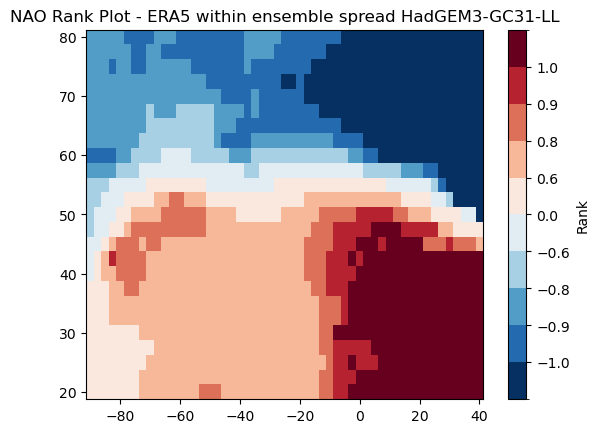

In [27]:
fig, ax = plt.subplots()

#levels = np.arange(-1.25, 1.5, 0.25)
levels = (-1.1,-1,-0.9, -0.8, -0.6, 0, 0.6, 0.8, 0.9, 1, 1.1)
norm = BoundaryNorm(levels, ncolors=256, clip=True)

pcm = ax.pcolormesh(
    anomaly['lon'], anomaly['lat'], anomaly,
    cmap='RdBu_r',
    norm=norm
)

cbar = fig.colorbar(pcm, ax=ax, boundaries=levels, ticks=levels[1:-1])
cbar.set_label('Rank')

ax.set_title('NAO Rank Plot - ERA5 within ensemble spread HadGEM3-GC31-LL')
plt.show()


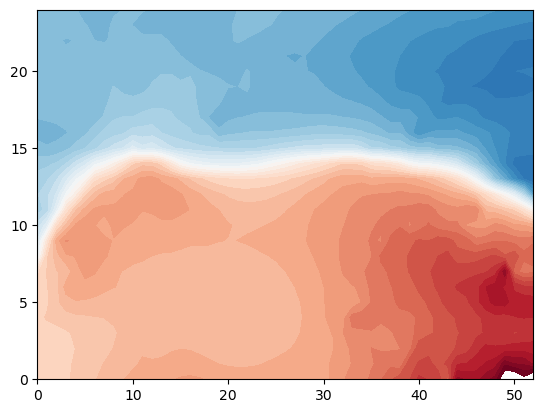

In [28]:
fig, ax = plt.subplots()

levels = np.arange(-2,2.1,0.1)
ax.contourf(anomaly, cmap='RdBu_r', levels=levels)

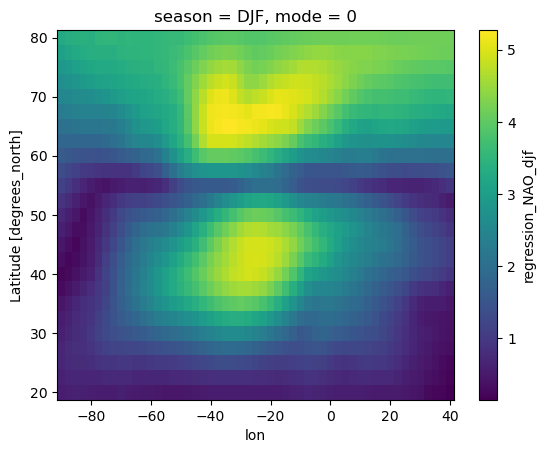

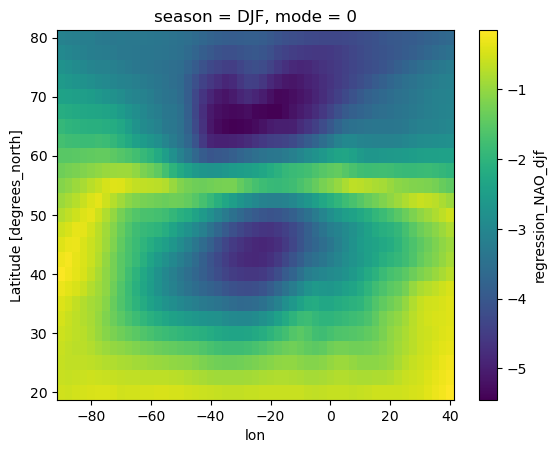

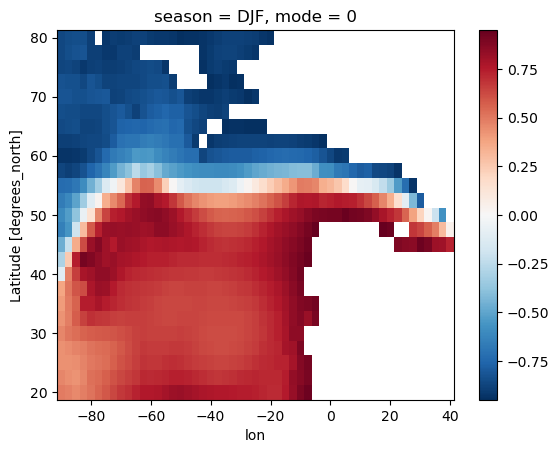

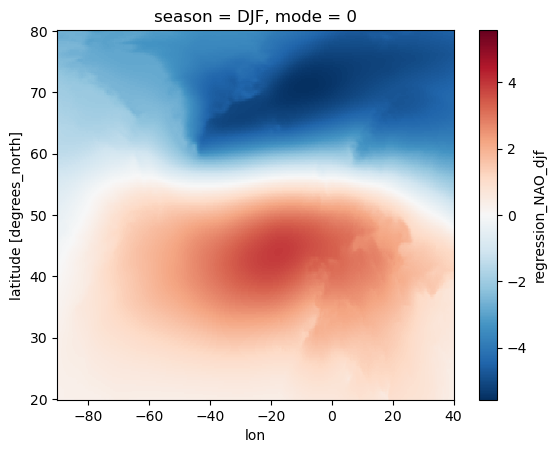

In [32]:
levels = np.arange(-1,1.1,0.1)

nao_max.plot()
#anomaly.plot(cmap='RdBu_r', center=0, levels=levels)
plt.show()
nao_min.plot()
plt.show()

masked_anomaly = anomaly.where((anomaly >= -0.95) & (anomaly <= 0.95))
masked_anomaly.plot(cmap='RdBu_r', center=0)
plt.show()

era5['regression_NAO_djf'].plot()
plt.show()

In [22]:
print(nao_max.values, nao_min.values)

[[ 0.14820247  0.1252403   0.10628727 ...  0.41425425  0.32754947
   0.25990416]
 [ 0.16299274  0.14381201  0.12980957 ...  0.41460578  0.34011621
   0.29877844]
 [ 0.19156848  0.17166193  0.1569837  ...  0.39011582  0.35226641
   0.32819492]
 ...
 [-0.11677623 -0.16378375 -0.2123822  ...  0.59103091  0.57246369
   0.55053491]
 [-0.22619193 -0.27490841 -0.31698666 ...  0.61266342  0.60638654
   0.58679303]
 [-0.22657695 -0.26018926 -0.28514236 ...  0.56480369  0.56777217
   0.59144731]] [[-0.25466742 -0.21517314 -0.18296002 ... -0.04255674 -0.05677919
  -0.04262855]
 [-0.25822595 -0.22595496 -0.19764591 ... -0.06344726 -0.05954406
  -0.04420115]
 [-0.26009    -0.24406518 -0.22905968 ... -0.07221039 -0.04088756
  -0.04013933]
 ...
 [-1.38975438 -1.46688618 -1.54413547 ... -1.48061999 -1.51630821
  -1.55160856]
 [-1.51540531 -1.5837585  -1.65534073 ... -1.23885376 -1.28867289
  -1.33943004]
 [-1.59892964 -1.65247965 -1.69708658 ... -1.19428571 -1.19176403
  -1.1933614 ]]


In [23]:
#folderpath for the ensemble files
folder = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/historical/HadGEM3-GC31-LL/'

ens_files = [os.path.join(folder, filename) for filename in os.listdir(folder) if 'regression_map' in filename]

print(len(ens_files))

#opening each ensemble file and storing in one multi-dim array with new dimension ensemble as well as prev lat, lons.
ds = xr.open_mfdataset(ens_files, concat_dim='ensemble', combine='nested')

#extracting the nao regression data
EA = ds['regression_EA_djf']

print(EA.dims)
print(EA.shape)

#extracting the max and min from the ensemble spread
EA_max = EA.max(dim='ensemble')
EA_min = EA.min(dim='ensemble')

#now time to import era5
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/era5/era5_DJF_EA_regression_map_1940-2024.nc')

#This creates a regridder so I can put era5 onto the ensemble grid
regridder = xe.Regridder(era5, EA_max, method='bilinear', periodic=False)
era5_regrid = regridder(era5['regression_EA_djf'])

spread = (EA_max - EA_min)/2
midpoint = nao_min + spread
anomaly = (era5_regrid - midpoint)/spread

print(anomaly)

56
('ensemble', 'lat', 'lon')
(56, 25, 53)
<xarray.DataArray (lat: 25, lon: 53)> Size: 11kB
dask.array<truediv, shape=(25, 53), dtype=float64, chunksize=(25, 53), chunktype=numpy.ndarray>
Coordinates:
    season   <U3 12B 'DJF'
    mode     int64 8B 1
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0


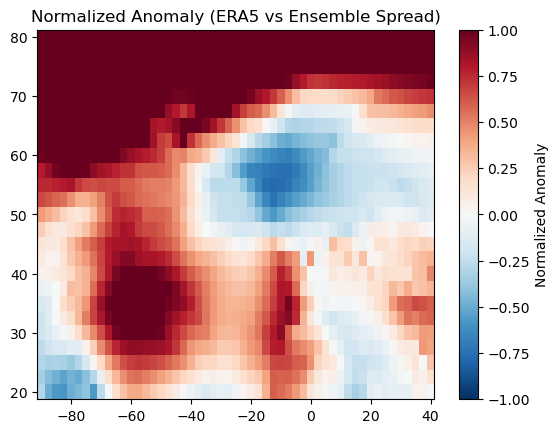

In [24]:
fig, ax = plt.subplots()

pcm = ax.pcolormesh(
    anomaly['lon'], anomaly['lat'], anomaly,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)

fig.colorbar(pcm, ax=ax, label='Normalized Anomaly')
ax.set_title('Normalized Anomaly (ERA5 vs Ensemble Spread)')
plt.show()

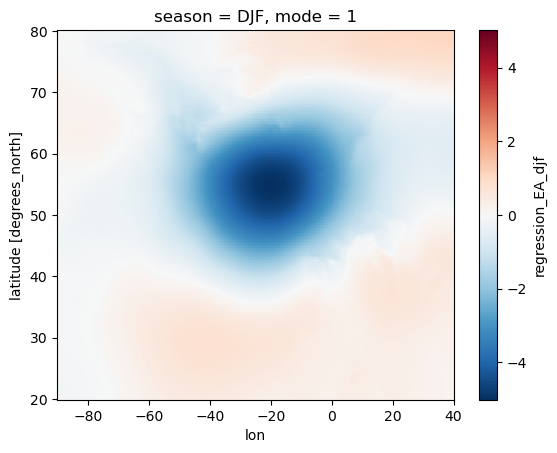

In [25]:
era5['regression_EA_djf'].plot()
plt.show()

In [26]:
#folderpath for the ensemble files
folder = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/historical/HadGEM3-GC31-LL/'

ens_files = [os.path.join(folder, filename) for filename in os.listdir(folder) if 'regression_map' in filename]

print(len(ens_files))

#opening each ensemble file and storing in one multi-dim array with new dimension ensemble as well as prev lat, lons.
ds = xr.open_mfdataset(ens_files, concat_dim='ensemble', combine='nested')

#extracting the nao regression data
NAO = ds['regression_NAO_djf']

print(NAO.dims)
print(NAO.shape)

#extracting the max and min from the ensemble spread
NAO_mean = NAO.mean(dim='ensemble')

NAO_concat = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_regression_map_1850-2015.nc')['regression_NAO_djf']

55
('ensemble', 'lat', 'lon')
(55, 25, 53)


In [27]:
#Cropping CVDP data to the North Atlantic sector - requires some shifting of 0 of the lat lon coordinate system.
def CVDP_EM_crop_NA_sector(filename, pattern):
    #function which will crop the historical ensemble mean CVDP output to the NA sector
    ds = xr.open_dataset(filename)
    ds = ds[pattern]
    
    #finding the longitudes that are greater than 180
    new_lon = np.where(ds.lon > 179, ds.lon -360, ds.lon)
    
    #creating a copy of the data array where the longitudes have been shifted
    ds_shifted = ds.copy()
    ds_shifted.coords['lon'] = new_lon
    
    #Now need to make sure they are in the correct order and then re-index to make sure the lon get put to match the sorted lon
    sorted_lon = np.sort(ds_shifted.lon)
    ds_shifted = ds_shifted.sel(lon=sorted_lon)
    
    historical_NAO_EM_shifted = ds_shifted.sel(lat=slice(20,80), lon=slice(-90,40))

    return historical_NAO_EM_shifted

NAO_CVDP = CVDP_EM_crop_NA_sector('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc', 'nao_pattern_djf_em')

-4.795419 4.1649313


/tmp/ipykernel_1650/3992767907.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


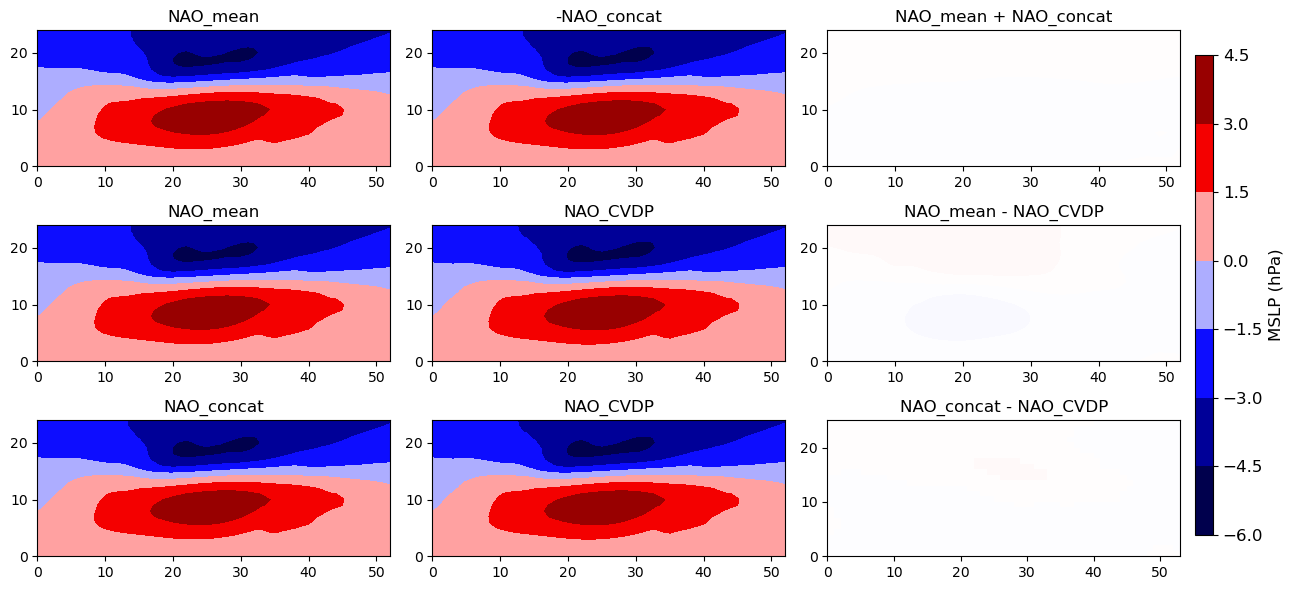

In [55]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 6))

# Calculate global vmin and vmax across all data to normalize colormap
all_data = [
    NAO_mean,
    -NAO_concat,
    NAO_mean + NAO_concat,
    NAO_mean,
    NAO_CVDP,
    NAO_mean - NAO_CVDP,
    -NAO_concat,
    NAO_CVDP,
    -NAO_concat-NAO_CVDP
]

vmin = min(np.nanmin(data) for data in all_data)
vmax = max(np.nanmax(data) for data in all_data)
print(vmin, vmax)

levels = np.arange(-4.8,5,0.2)
cmap='seismic'

norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot each with the same colormap range
contour = ax[0,0].contourf(NAO_mean, norm=norm, cmap=cmap)
ax[0,0].set_title("NAO_mean")

ax[0,1].contourf(-NAO_concat, norm=norm, cmap=cmap)
ax[0,1].set_title("-NAO_concat")

ax[0,2].contourf(NAO_mean + NAO_concat, norm=norm, cmap=cmap)
ax[0,2].set_title("NAO_mean + NAO_concat")

ax[1,0].contourf(NAO_mean, norm=norm, cmap=cmap)
ax[1,0].set_title("NAO_mean")

ax[1,1].contourf(NAO_CVDP, norm=norm, cmap=cmap)
ax[1,1].set_title("NAO_CVDP")

ax[1,2].contourf(NAO_mean - NAO_CVDP, norm=norm, cmap=cmap)
ax[1,2].set_title("NAO_mean - NAO_CVDP")

ax[2,0].contourf(-NAO_concat, norm=norm, cmap=cmap)
ax[2,0].set_title("NAO_concat")

ax[2,1].contourf(NAO_CVDP, norm=norm, cmap=cmap)
ax[2,1].set_title("NAO_CVDP")

ax[2,2].pcolormesh(-NAO_concat - NAO_CVDP, norm=norm, cmap=cmap)
ax[2,2].set_title("NAO_concat - NAO_CVDP")

#ticks = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]

# Add colorbar
cax = fig.add_axes([1, 0.1, 0.015, 0.8])
cbar = fig.colorbar(contour, cax=cax, orientation='vertical')
cbar.set_label('MSLP (hPa)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


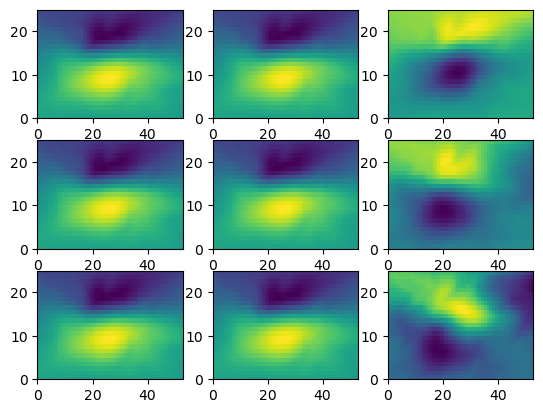

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3)
ax[0,0].pcolormesh(NAO_mean)
ax[0,1].pcolormesh(-NAO_concat)
ax[0,2].pcolormesh(NAO_mean+NAO_concat)

ax[1,0].pcolormesh(NAO_mean)
ax[1,1].pcolormesh(NAO_CVDP)
ax[1,2].pcolormesh(NAO_mean-NAO_CVDP)

ax[2,0].pcolormesh(-NAO_concat)
ax[2,1].pcolormesh(NAO_CVDP)
ax[2,2].pcolormesh(-NAO_concat-NAO_CVDP)

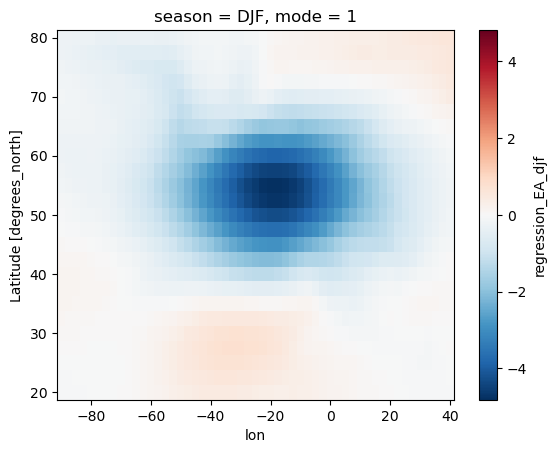

In [9]:
file = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r12i1p1f3_DJF_EA_regression_map_1850-2015.nc'

#opening each ensemble file and storing in one multi-dim array with new dimension ensemble as well as prev lat, lons.
ds = xr.open_dataset(file)

#extracting the nao regression data
nao = ds['regression_EA_djf']
nao.plot()